In [3]:
# jupyter notebooks header --------------------------------------------------------------
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import numpy as np
import torch
from matplotlib import pyplot as plt
import pprint
from tqdm.notebook import tqdm

# need to set gpus before anything involving pytorch
from config import cfg
import os
cfg.CONST.DEVICE = "4"
os.environ["CUDA_VISIBLE_DEVICES"] = cfg.CONST.DEVICE

import utils.data_loaders
import utils.data_transforms
import utils.network_utils
import utils.binvox_visualization
from models.encoder import Encoder
from models.decoder import Decoder
from models.refiner import Refiner
from models.merger import Merger
from models.classifier import Classifier


In [5]:

IMG_SIZE = cfg.CONST.IMG_H, cfg.CONST.IMG_W
CROP_SIZE = cfg.CONST.CROP_IMG_H, cfg.CONST.CROP_IMG_W
train_transforms = utils.data_transforms.Compose([
    utils.data_transforms.RandomCrop(IMG_SIZE, CROP_SIZE),
    utils.data_transforms.RandomBackground(cfg.TRAIN.RANDOM_BG_COLOR_RANGE),
    #utils.data_transforms.ColorJitter(cfg.TRAIN.BRIGHTNESS, cfg.TRAIN.CONTRAST, cfg.TRAIN.SATURATION),
    #utils.data_transforms.RandomNoise(cfg.TRAIN.NOISE_STD),
    #utils.data_transforms.Normalize(mean=cfg.DATASET.MEAN, std=cfg.DATASET.STD),
    #utils.data_transforms.RandomFlip(),
    #utils.data_transforms.RandomPermuteRGB(),
    utils.data_transforms.ToTensor(),
])

cfg.DATASET.CLASSES_TO_USE = ['car', 'display', 'lamp']
cfg.CONST.BATCH_SIZE = 1
cfg.DATASET.USE_PLACES = False
cfg.CONST.N_VIEWS_RENDERING = 1
#
train_dataset_loader = utils.data_loaders.DATASET_LOADER_MAPPING[cfg.DATASET.TRAIN_DATASET](cfg)

train_data = train_dataset_loader.get_dataset(utils.data_loaders.DatasetType.TRAIN,
                                             cfg.CONST.N_VIEWS_RENDERING, train_transforms, classes_filter = cfg.DATASET.CLASSES_TO_USE)
train_data_loader = torch.utils.data.DataLoader(
    dataset= train_data,
    batch_size=cfg.CONST.BATCH_SIZE,
    num_workers=cfg.TRAIN.NUM_WORKER,
    pin_memory=True,
    shuffle=True,
    drop_last=True)

# setting up architectures and loading saved params
encoder = Encoder(cfg)
decoder = Decoder(cfg)
refiner = Refiner(cfg)
merger = Merger(cfg)
encoder = torch.nn.DataParallel(encoder).cuda()
decoder = torch.nn.DataParallel(decoder).cuda()
refiner = torch.nn.DataParallel(refiner).cuda()
merger = torch.nn.DataParallel(merger).cuda()

trial_name ="2020_03_03--19_54_23_train_on_places_full"
#weights_path = "./output/{}/checkpoints/best-ckpt.pth".format(trial_name)
weights_path = "./saved_params/Pix2Vox-A-ShapeNet.pth"
cfg.CONST.WEIGHTS = weights_path
checkpoint = torch.load(cfg.CONST.WEIGHTS)

encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])
if cfg.NETWORK.USE_REFINER:
    refiner.load_state_dict(checkpoint['refiner_state_dict'])
if cfg.NETWORK.USE_MERGER:
    merger.load_state_dict(checkpoint['merger_state_dict'])

[INFO] 2020-03-15 16:11:33.012547 Loading cache of Taxonomy[ID=02958343, Name=car, Partition=train]
[INFO] 2020-03-15 16:11:33.099888 Loading cache of Taxonomy[ID=03211117, Name=display, Partition=train]
[INFO] 2020-03-15 16:11:33.111349 Loading cache of Taxonomy[ID=03636649, Name=lamp, Partition=train]
[INFO] 2020-03-15 16:11:33.228031 Complete collecting files of the dataset. Total files: 7634.


# Batch mean get

In [41]:
# initalize the class mean shapes for the current batch's classes
shapenetID2Name = {
    "02691156":"aeroplane",
    "02828884":"bench",
    "02933112":"cabinet",
    "02958343":"car",
    "03001627":"chair",
    "03211117":"display",
    "03636649":"lamp",
    "03691459":"speaker",
    "04090263":"rifle",
    "04256520":"sofa",
    "04379243":"table",
    "04401088":"telephone",
    "04530566":"watercraft"
    }
def get_batch_mean_features(class_mean_features, feature_map_shape, batch_classes):
    num_views = feature_map_shape[1]
    batch_class_mean_features = []
    for batch_idx, class_id in enumerate(batch_classes):
        class_name = shapenetID2Name[class_id]
        y = torch.cat([class_mean_features[class_name] for i in range(num_views)], dim=1)
        batch_class_mean_features.append(y)
    batch_class_mean_features = torch.cat(batch_class_mean_features, dim = 0)
    return batch_class_mean_features

In [48]:
class_mean_features = torch.load(cfg.DIR.MEAN_FEATURES_PATH)
for (taxonomy_names, sample_names, rendering_images,
                        ground_truth_volumes, ground_truth_class_labels) in train_data_loader:
    #print(taxonomy_names) 
    #print(rendering_images.shape)
    image_features = encoder(rendering_images)
    b = get_batch_mean_features(class_mean_features,image_features.shape, taxonomy_names)
    print(b.shape)
    cls_i = 0
    for i in range(b.shape[0]):
        for j in range(b.shape[1]):
            a = b[i][j]
            c = class_mean_features[shapenetID2Name[taxonomy_names[cls_i]]][0][0]
            print(a.shape, c.shape)
            print(torch.equal(a,c))
        cls_i+=1
    
    #print(b.shape)
    #test_img = rendering_images[0][0].cpu().numpy()
    #test_img = np.transpose(test_img, (1,2,0))
    #plt.imshow(test_img)
    break

torch.Size([64, 2, 256, 8, 8])
torch.Size([256, 8, 8]) torch.Size([256, 8, 8])
True
torch.Size([256, 8, 8]) torch.Size([256, 8, 8])
True
torch.Size([256, 8, 8]) torch.Size([256, 8, 8])
True
torch.Size([256, 8, 8]) torch.Size([256, 8, 8])
True
torch.Size([256, 8, 8]) torch.Size([256, 8, 8])
True
torch.Size([256, 8, 8]) torch.Size([256, 8, 8])
True
torch.Size([256, 8, 8]) torch.Size([256, 8, 8])
True
torch.Size([256, 8, 8]) torch.Size([256, 8, 8])
True
torch.Size([256, 8, 8]) torch.Size([256, 8, 8])
True
torch.Size([256, 8, 8]) torch.Size([256, 8, 8])
True
torch.Size([256, 8, 8]) torch.Size([256, 8, 8])
True
torch.Size([256, 8, 8]) torch.Size([256, 8, 8])
True
torch.Size([256, 8, 8]) torch.Size([256, 8, 8])
True
torch.Size([256, 8, 8]) torch.Size([256, 8, 8])
True
torch.Size([256, 8, 8]) torch.Size([256, 8, 8])
True
torch.Size([256, 8, 8]) torch.Size([256, 8, 8])
True
torch.Size([256, 8, 8]) torch.Size([256, 8, 8])
True
torch.Size([256, 8, 8]) torch.Size([256, 8, 8])
True
torch.Size([256

# Mean Shape

In [99]:
encoder.eval()

# making mean shape for all classes
class_names = ["aeroplane","bench","cabinet", "car", "chair", "display", "lamp","speaker","rifle", "sofa", "table","telephone", "watercraft"]
class_mean_shapes = {}
with torch.no_grad():
    for class_name in class_names:
        # prepping class datalodaer
        cfg.DATASET.CLASSES_TO_USE = class_name
        cfg.CONST.BATCH_SIZE = 1
        cfg.DATASET.USE_PLACES = False
        cfg.CONST.N_VIEWS_RENDERING = 1

        train_dataset_loader = utils.data_loaders.DATASET_LOADER_MAPPING[cfg.DATASET.TRAIN_DATASET](cfg)
        train_data = train_dataset_loader.get_dataset(utils.data_loaders.DatasetType.TRAIN,
                                                     cfg.CONST.N_VIEWS_RENDERING, train_transforms, classes_filter = cfg.DATASET.CLASSES_TO_USE)
        train_data_loader = torch.utils.data.DataLoader(
            dataset= train_data,
            batch_size=cfg.CONST.BATCH_SIZE,
            num_workers=cfg.TRAIN.NUM_WORKER,
            pin_memory=True,
            shuffle=True,
            drop_last=True)
    
        # generating mean shape
        all_image_features = []
        for i, (_, _, rendering_image, _, _) in enumerate(tqdm(train_data_loader)):
            image_feature = encoder(rendering_image)
            all_image_features.append(image_feature)

        class_mean_shape = torch.mean(torch.stack(all_image_features), dim=0)
        class_mean_shapes[class_name] = class_mean_shape
        
torch.save(class_mean_shapes, "./class_mean_shapes.p")

[INFO] 2020-03-13 15:20:42.299157 Loading cache of Taxonomy[ID=02691156, Name=aeroplane, Partition=train]
[INFO] 2020-03-13 15:20:42.327186 Complete collecting files of the dataset. Total files: 2831.



[INFO] 2020-03-13 15:21:10.536592 Loading cache of Taxonomy[ID=02828884, Name=bench, Partition=train]
[INFO] 2020-03-13 15:21:10.553605 Complete collecting files of the dataset. Total files: 1271.



[INFO] 2020-03-13 15:21:47.146803 Loading cache of Taxonomy[ID=02933112, Name=cabinet, Partition=train]
[INFO] 2020-03-13 15:21:47.163799 Complete collecting files of the dataset. Total files: 1100.



[INFO] 2020-03-13 15:22:32.927022 Loading cache of Taxonomy[ID=02958343, Name=car, Partition=train]
[INFO] 2020-03-13 15:22:32.995404 Complete collecting files of the dataset. Total files: 5246.



[INFO] 2020-03-13 15:26:50.415972 Loading cache of Taxonomy[ID=03001627, Name=chair, Partition=train]
[INFO] 2020-03-13 15:26:50.465495 Complete collecting files of the dataset. Total files: 4744.



[INFO] 2020-03-13 15:28:59.116181 Loading cache of Taxonomy[ID=03211117, Name=display, Partition=train]
[INFO] 2020-03-13 15:28:59.123996 Complete collecting files of the dataset. Total files: 766.



[INFO] 2020-03-13 15:29:45.800225 Loading cache of Taxonomy[ID=03636649, Name=lamp, Partition=train]
[INFO] 2020-03-13 15:29:45.818000 Complete collecting files of the dataset. Total files: 1622.



[INFO] 2020-03-13 15:30:05.347897 Loading cache of Taxonomy[ID=03691459, Name=speaker, Partition=train]
[INFO] 2020-03-13 15:30:05.366739 Complete collecting files of the dataset. Total files: 1132.



[INFO] 2020-03-13 15:30:42.823818 Loading cache of Taxonomy[ID=04090263, Name=rifle, Partition=train]
[INFO] 2020-03-13 15:30:42.839356 Complete collecting files of the dataset. Total files: 1660.



[INFO] 2020-03-13 15:31:12.504532 Loading cache of Taxonomy[ID=04256520, Name=sofa, Partition=train]
[INFO] 2020-03-13 15:31:12.534443 Complete collecting files of the dataset. Total files: 2221.



[INFO] 2020-03-13 15:31:58.041598 Loading cache of Taxonomy[ID=04379243, Name=table, Partition=train]
[INFO] 2020-03-13 15:31:58.105883 Complete collecting files of the dataset. Total files: 5956.



[INFO] 2020-03-13 15:33:36.239569 Loading cache of Taxonomy[ID=04401088, Name=telephone, Partition=train]
[INFO] 2020-03-13 15:33:36.249329 Complete collecting files of the dataset. Total files: 736.



[INFO] 2020-03-13 15:33:53.781068 Loading cache of Taxonomy[ID=04530566, Name=watercraft, Partition=train]
[INFO] 2020-03-13 15:33:53.796995 Complete collecting files of the dataset. Total files: 1357.


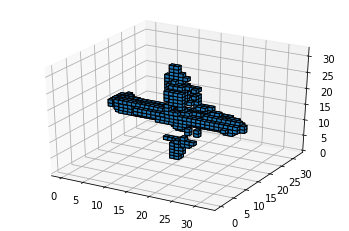

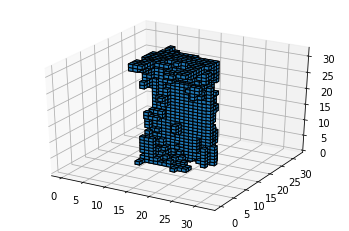

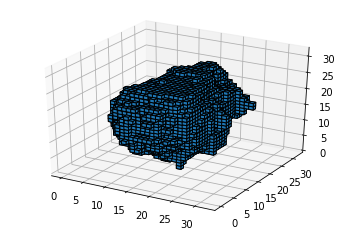

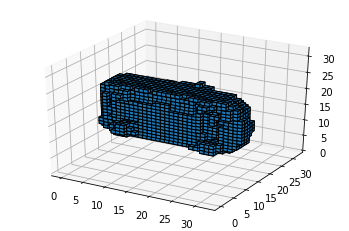

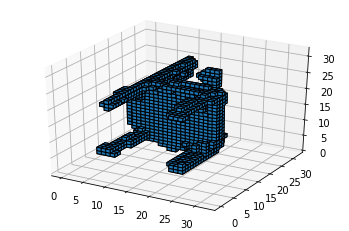

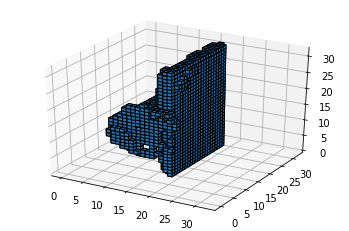

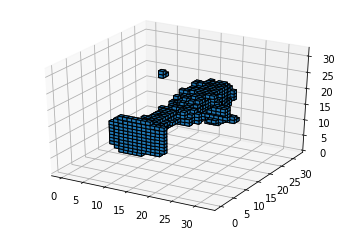

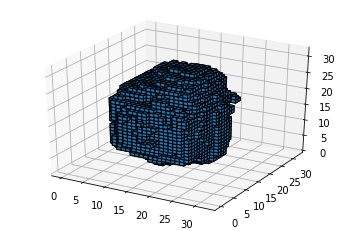

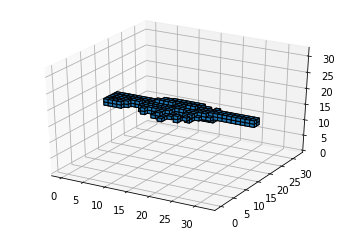

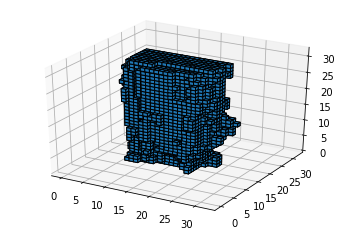

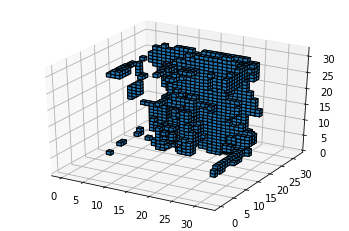

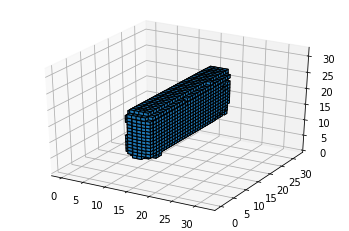

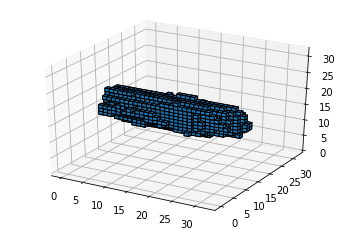

In [9]:
class_names = ["aeroplane","bench","cabinet", "car", "chair", "display", "lamp","speaker","rifle", "sofa", "table","telephone", "watercraft"]
class_mean_shapes = torch.load("./caches/class_mean_shapes.p")
for class_name in class_names:
    class_mean_shape = class_mean_shapes[class_name]
    with torch.no_grad():
        raw_features, generated_volume = decoder(class_mean_shape)
        generated_volume = merger(raw_features, generated_volume)
        generated_volume = refiner(generated_volume)

    # visualizing reconstructions
    #th = 0.5
    #vox = utils.binvox_rw.Voxels(volume.ge(th).cpu().squeeze().numpy(), (32,) * 3, (0,) * 3, 1, 'xyz')
    #vox.write(f)
    fig, ax = utils.binvox_visualization.get_volume_views(generated_volume.cpu().numpy(), None, None, save = False)

In [104]:
class_mean_shapes = torch.load("./caches/class_mean_shapes.p")
print(class_mean_shapes['car'].shape)

torch.Size([1, 1, 256, 8, 8])


In [ ]:
# find shape closes to mean shape


# Interpolations

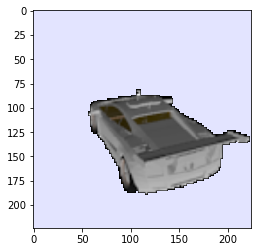

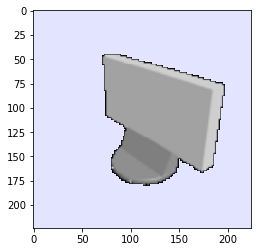

In [84]:
_, _, rendering_image1, _, _= next(iter(train_data_loader))
_, _, rendering_image2, _, _ = next(iter(train_data_loader))

test_img = rendering_image1[0][0].cpu().numpy()
test_img = np.transpose(test_img, (1,2,0))
plt.imshow(test_img)
plt.show()

test_img = rendering_image2[0][0].cpu().numpy()
test_img = np.transpose(test_img, (1,2,0))
plt.imshow(test_img)
plt.show()

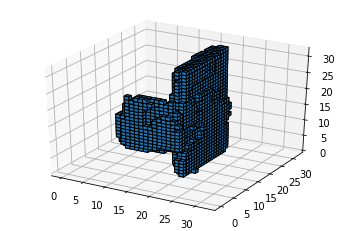

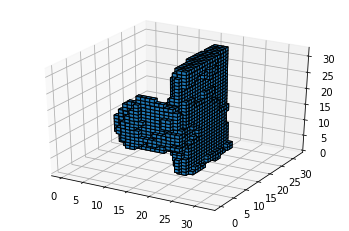

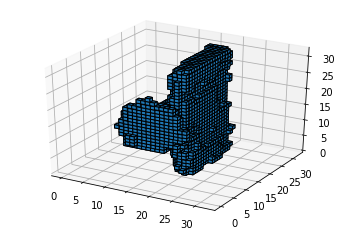

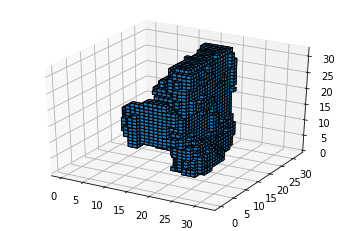

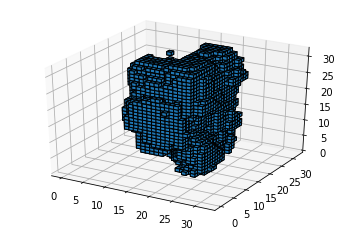

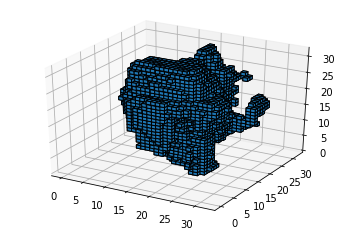

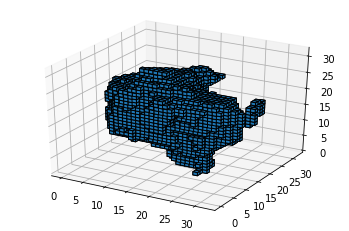

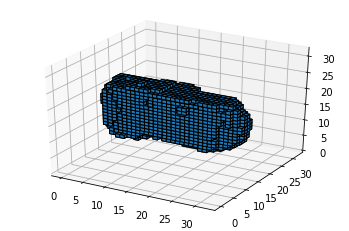

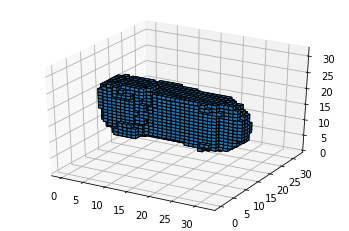

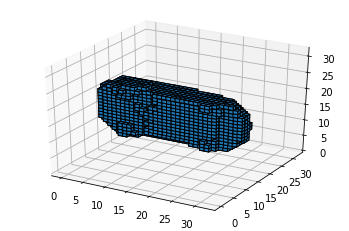

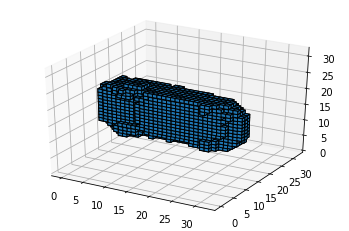

In [85]:
encoder.eval()
decoder.eval()

# creating latent feature maps
with torch.no_grad():
    image_feature1 = encoder(rendering_image1)
    image_feature2 = encoder(rendering_image2)

#img_feature_list = [image_feature1, image_feature2]
feature_size = image_feature1.shape
# reshaping feature maps into vectors
img_feature_list = []
for alpha in np.arange(0,1.1,0.1):
    image_lat_vec1 = image_feature1.view(-1)
    image_lat_vec2 = image_feature2.view(-1)
    interpolated_lat_vec = alpha*image_lat_vec1 + (1-alpha)*image_lat_vec2
    interpolated_feature = interpolated_lat_vec.view(feature_size)
    img_feature_list.append(interpolated_feature)

for image_feature in img_feature_list:
    with torch.no_grad():
        raw_features, volume = decoder(image_feature)

    # visualizing reconstructions
    th = 0.5
    #vox = utils.binvox_rw.Voxels(volume.ge(th).cpu().squeeze().numpy(), (32,) * 3, (0,) * 3, 1, 'xyz')
    #vox.write(f)
    fig, ax = utils.binvox_visualization.get_volume_views(volume.cpu().numpy(), None, None, save = False)

# legacy code

In [ ]:
for (taxonomy_names, sample_names, rendering_images,
                        ground_truth_volumes, ground_truth_class_labels) in train_data_loader:
    print(taxonomy_names) 
    print(rendering_images.shape)
    ground_truth_class_labels = ground_truth_class_labels.repeat(4,1).T
    test_img = rendering_images[0][0].cpu().numpy()
    test_img = np.transpose(test_img, (1,2,0))
    plt.imshow(test_img)
    break